# 1. LeNet : 최초의 CNN
```
<img src='./image/LeNet.png' alt='LeNet'>
```
![LeNet](image/LeNet.png)

FC(120) : 120개 출력층의 뉴런을 가진 FUlly Connected 레이어

In [1]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, AvgPool2D, Flatten, Dense
                                            # AveragePooling2D 동일
from tensorflow.keras.callbacks import EarlyStopping, Callback
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
class CustomHistory(Callback): # on_epoch_end()는 각 에포크 종료시 호출
    def __init__(self, times=5):  # 생성자 함수
        self.epoch = 0
        self.times = times
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if self.epoch%self.times == 0:
            print('epoch:{}, loss:{}, acc:{}, val_loss:{}, val_accuracy:{}'.\
                 format(self.epoch,
                        logs.get('loss'),
                        logs.get('accuracy'),
                        logs.get('val_loss'),
                        logs.get('val_accuracy')
                       ))

In [3]:
# 출력사이즈 = (입력사이즈 - 커널사이즈)/스트라이드 + 1
class LeNet:
    @staticmethod
    def build(input_shape=(32,32,1), activation='relu'):
        model = Sequential()
        model.add(Input(shape=input_shape))
        model.add(Conv2D(6, # 커널 갯수
                         kernel_size=(5,5),
                         activation=activation,
                         kernel_initializer='he_normal',
                         padding='valid'
                        )) # C1층
        model.add(AvgPool2D(pool_size=(2,2),
                            strides=2, # 스트라이드 사이즈는 기본이 pool_size
                            # strides=(2,2)
                           )) # P2층
        model.add(Conv2D(16, kernel_size=(5,5),
                         activation=activation,
                         kernel_initializer='he_normal'
                        )) # C3 층
        model.add(AvgPool2D(pool_size=(2,2), strides=2)) # P4층
        model.add(Flatten())
        model.add(Dense(120, activation='relu', kernel_initializer='he_normal')) # F5층
        model.add(Dense(84, activation='relu', kernel_initializer='he_normal')) # F6층
        model.add(Dense(10, activation='softmax')) # 출력층
        return model

In [4]:
model = LeNet.build(input_shape=(28,28,1), activation='relu')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 4, 4, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               3

In [5]:
# 1. 데이터
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train = X_train.reshape(-1, 28,28,1)/255.0
X_test = X_test.reshape(-1, 28,28,1)/255.0
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [7]:
# 2. 모델생성
model = LeNet.build(input_shape=(28,28,1))

# 3. 학습설정
model.compile(loss='sparse_categorical_crossentropy', # 원핫인코딩을 안 하고 분류 분석
              optimizer='adam',
              metrics=['accuracy']              
             )
# 4. 학습
customHistory = CustomHistory(3)
earlystopping = EarlyStopping(patience=10)
hist = model.fit(X_train, y_train,
                 validation_split=0.2,
                 epochs=50,
                 callbacks=[customHistory, earlystopping],
                 verbose=0
                )

epoch:3, loss:0.05744081735610962, acc:0.9821666479110718, val_loss:0.0796474888920784, val_accuracy:0.9783333539962769
epoch:6, loss:0.03030666895210743, acc:0.9906041622161865, val_loss:0.05207090079784393, val_accuracy:0.9859166741371155
epoch:9, loss:0.018474336713552475, acc:0.9936666488647461, val_loss:0.05198904871940613, val_accuracy:0.9860000014305115
epoch:12, loss:0.01345708966255188, acc:0.9955833554267883, val_loss:0.049952734261751175, val_accuracy:0.9880833625793457
epoch:15, loss:0.009794723242521286, acc:0.996999979019165, val_loss:0.0597689114511013, val_accuracy:0.9867500066757202
epoch:18, loss:0.006834747269749641, acc:0.9979583621025085, val_loss:0.06308106333017349, val_accuracy:0.9878333210945129
epoch:21, loss:0.00811549462378025, acc:0.9973333477973938, val_loss:0.06788072735071182, val_accuracy:0.9872499704360962


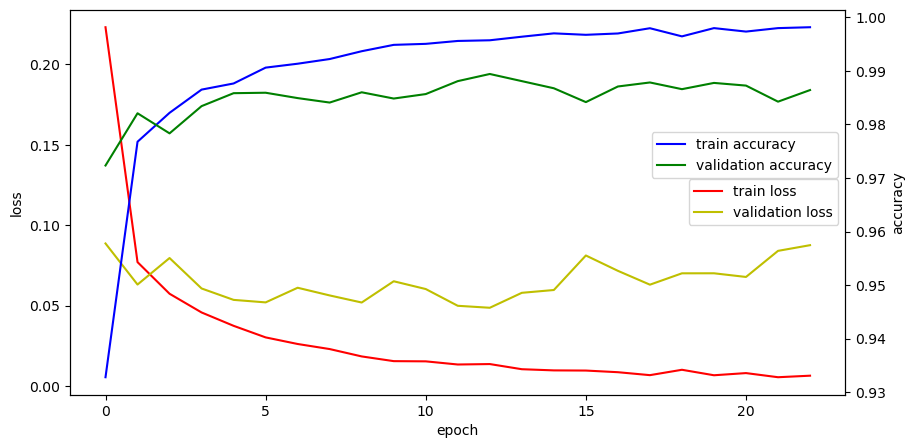

In [8]:
# 5. 학습과정 살펴보기
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')

acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [9]:
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:2f}%'.format(accuracy*100))

313/313 [==============================] - 1s 2ms/step - loss: 0.0732 - accuracy: 0.9870
accuracy : 98.699999%


In [10]:
# 예측치와 실제값을 이용한 교차표
yhat = model.predict(X_test).argmax(axis=1)
display(pd.crosstab(y_test, yhat)) # 결과가 데이터프레임
# print(confusion_matrix(y_test, yhat)) # 결과가 넘파이배열
cnt = 0
for y, h in zip(y_test, yhat):
    if y!=h:
        cnt += 1
print('예측이 틀린 갯수 :',cnt)

313/313 [==============================] - 0s 1ms/step


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,979,0,0,0,0,0,0,1,0,0
1,3,1129,1,0,0,0,1,0,0,1
2,2,3,1025,0,0,0,0,2,0,0
3,0,1,2,994,0,4,0,5,2,2
4,0,2,1,0,973,0,3,1,0,2
5,2,0,0,9,0,876,3,1,1,0
6,12,2,2,0,2,1,939,0,0,0
7,0,2,4,0,0,0,0,1020,0,2
8,4,2,4,3,1,3,1,3,950,3


예측이 틀린 갯수 : 130


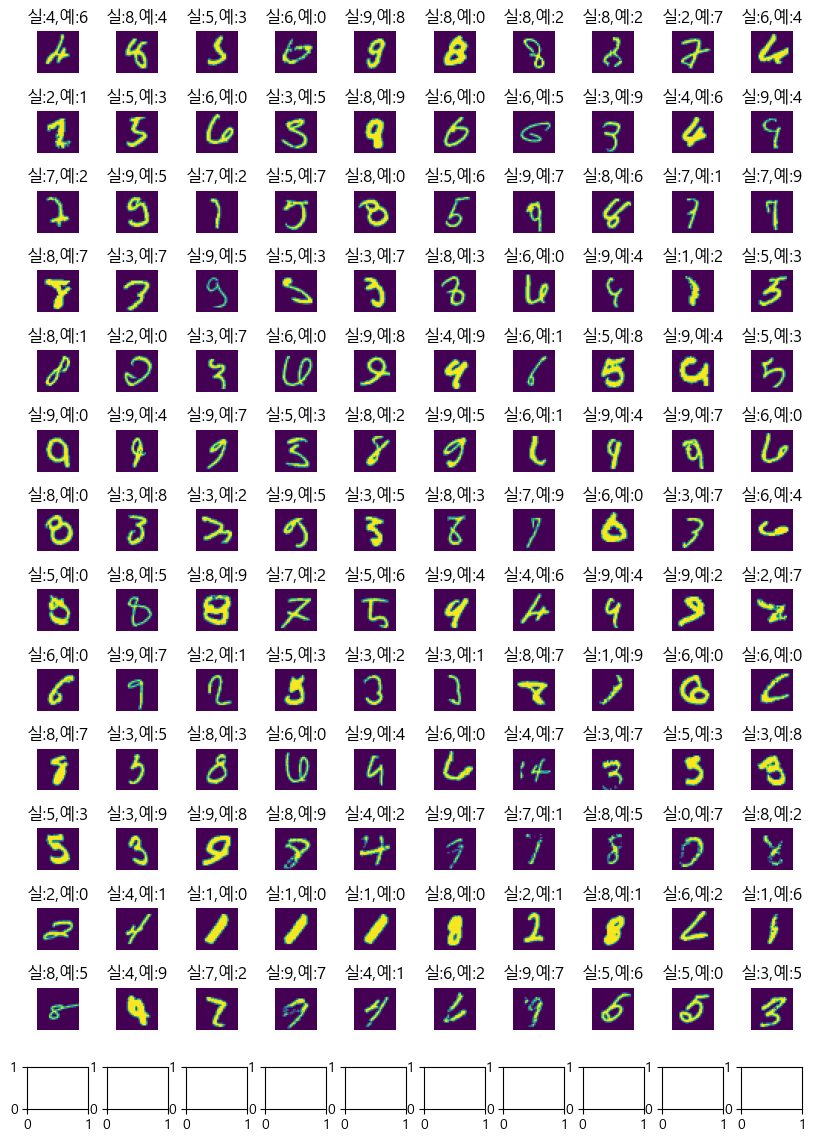

In [11]:
# 모델 학습 후 틀린 데이터 출력용(X_test와 Y_test)
plt_row = cnt//10 + 1
plt_col = 10

plt.rcParams['figure.figsize'] = (plt_col, plt_row)

plt.rc('font',family='Malgun Gothic') # 윈도우즈 os

fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
plt.subplots_adjust(hspace=0.9, wspace=0.3)

i = 0 # yhat과 y_test를 액세스할 indexx
cnt = 0 # 출력할 횟수
while (cnt<plt_row*plt_col) & (i < len(y_test)):
    # 예측한 결과가 틀렸을 경우만 imshow(y_test[i]), 실제값과 예측치를 title에 출력
    if yhat[i]==y_test[i]:
        i += 1
        continue
    # 예측한 값과 실제값이 다른 경우
    sub_plot = axarr[cnt//plt_col, cnt%plt_col]
    sub_plot.imshow(X_test[i].reshape(28,28))
    title = '실:{},예:{}'.format(y_test[i], yhat[i])
    sub_plot.set_title(title)
    sub_plot.axis('off')
    i+=1
    cnt+=1

# 2. AlexNet
- GPU를 사용하여 실현 가능한 모델. 알렉스와 제프리힌튼이 공동 설게한 CNN 아키텍쳐 이름

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization # 배치정규화
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [13]:
# 출력사이즈 = (입력사이즈-커널사이즈)/스트라이드 + 1
class AlexNet:
    @staticmethod
    def build(input_shape=(224,224,3), activation='relu', class_num=1000):
        model = Sequential([
            Input(shape=input_shape),
            Conv2D(96, # 커널갯수
                   kernel_size=(11,11), strides=(4,4),
                   activation=activation,
                   padding='same'
                  ),
            MaxPooling2D(pool_size=(3,3), strides=2),
            BatchNormalization(), # 배치 정규화
            Conv2D(256, kernel_size=(5,5), activation=activation,
                  padding='same'),
            MaxPooling2D(pool_size=(3,3), strides=2),
            BatchNormalization(),
            
            Conv2D(384, kernel_size=(3,3), activation=activation,
                  padding='same'),
            Conv2D(384, kernel_size=(3,3), activation=activation,
                  padding='same'),
            Conv2D(256, kernel_size=(3,3), activation=activation,
                  padding='same'),
            # AlexNet은 224*224 이미지에 맞춰서 3*3 pooling이 되나,
            # cifar 32*32 이밎에서는 생략
            # MaxPooling2D(pool_size=(3,3), strides=2),
            Flatten(),
            Dense(units=4096, activation=activation),
            Dropout(0.5),
            Dense(units=4096, activation=activation),
            Dropout(0.5),
            Dense(units=class_num, activation='softmax')
        ])
        return model

In [14]:
model = AlexNet.build(input_shape=(32,32,3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 8, 8, 96)          34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 96)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 3, 3, 96)         384       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 256)         614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 256)        0         
 2D)                                                             
                                                      

In [15]:
# 1. 데이터 (원핫인코딩 X)
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

170498071/170498071 [==============================] - 18s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

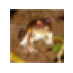

array([6], dtype=uint8)

In [16]:
# airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
plt.figure(figsize=(0.7,0.7))
plt.imshow(X_train[0])
plt.axis('off')
plt.show()
y_train[0]

In [17]:
# 스케일 조정
X_train = X_train/255.0
X_test = X_test/255.0
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [18]:
# 2. 모델
# model = AlexNet.build(input_shape=(32,32,3), class_num=10)
model = Sequential([
            Input(shape=(32,32,3)),
            Conv2D(96, # 커널갯수
                   kernel_size=(11,11), strides=(4,4),
                   activation='relu',
                   padding='same'
                  ), # => 파라미터수 : 11*11*96*3(채널수) + 96(출력수) = 34,944
            MaxPooling2D(pool_size=(3,3), strides=2),
            BatchNormalization(), # 배치 정규화
            
            Conv2D(384, kernel_size=(3,3), activation='relu',
                  padding='same'), # => 파라미터수 : 96*3*3*384 + 384 = 332,160
            Conv2D(256, kernel_size=(3,3), activation='relu',
                  padding='same'), # => 파라미터수 : 384*3*3*256 + 256

            Flatten(),
            Dense(units=1024, activation='relu'),
            Dropout(0.3),
            Dense(units=512, activation='relu'),
            Dropout(0.3),
            Dense(units=10, activation='softmax')
        ])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 8, 8, 96)          34944     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 96)         0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 3, 3, 96)         384       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 3, 3, 384)         332160    
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 256)         884992    
                                                                 
 flatten_3 (Flatten)         (None, 2304)             

In [19]:
# 3. 학습설정
model.compile(loss='sparse_categorical_crossentropy', #원핫인코딩 안 했을 경우
              optimizer='adam',
              metrics=['accuracy']
             )
hist = model.fit(X_train, y_train,
                epochs=20,
                validation_data=[X_test, y_test])

Epoch 1/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6335 - accuracy: 0.4082 - val_loss: 1.4285 - val_accuracy: 0.4956
Epoch 2/20
1563/1563 [==============================] - 7s 4ms/step - loss: 1.3609 - accuracy: 0.5211 - val_loss: 1.5708 - val_accuracy: 0.4687
Epoch 3/20
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2374 - accuracy: 0.5690 - val_loss: 1.2665 - val_accuracy: 0.5508
Epoch 4/20
1563/1563 [==============================] - 7s 4ms/step - loss: 1.1315 - accuracy: 0.6047 - val_loss: 1.2485 - val_accuracy: 0.5697
Epoch 5/20
1563/1563 [==============================] - 7s 4ms/step - loss: 1.0447 - accuracy: 0.6340 - val_loss: 1.2417 - val_accuracy: 0.5658
Epoch 6/20
1563/1563 [==============================] - 7s 4ms/step - loss: 0.9707 - accuracy: 0.6622 - val_loss: 1.2244 - val_accuracy: 0.5737
Epoch 7/20
1563/1563 [==============================] - 7s 4ms/step - loss: 0.8963 - accuracy: 0.6882 - val_loss: 1.3669 - val_accuracy:

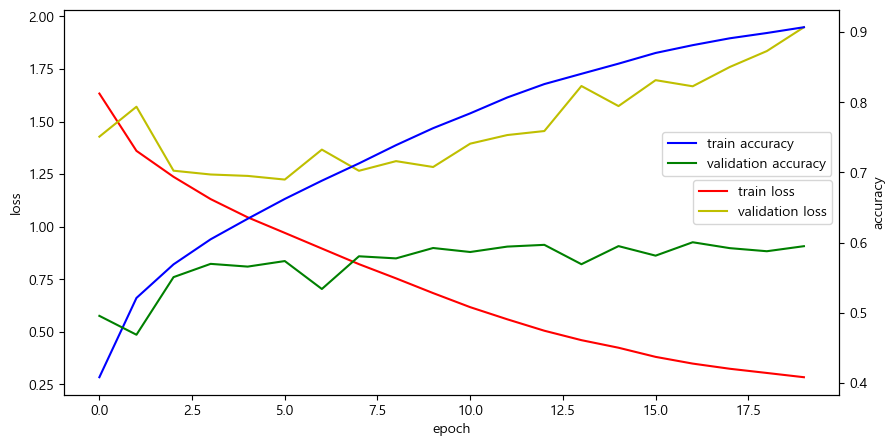

In [20]:
# 5. 모델 평가 - 학습과정 살펴보기, 모델 평가, 교차표
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')

acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [21]:
# 5. 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print('loss :',loss)
print('accuracy :',accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 1.9490 - accuracy: 0.5949
loss : 1.948974609375
accuracy : 0.5949000120162964


In [22]:
# 5. 모델 평가 : 교차표
# airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
# y_test.reshape(-1) # 실제값 1차원
y_hat = np.argmax(model.predict(X_test), axis=1)
ctab = pd.crosstab(y_test.reshape(-1), y_hat)
ctab.columns=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']
ctab.columns.name='predict'
ctab.index = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']
ctab.index.name ='real'
ctab

313/313 [==============================] - 0s 1ms/step


predict,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
real,,,,,,,,,,
airplane,718,19,32,12,25,7,12,15,103,57
automobile,32,692,13,16,5,11,4,7,40,180
bird,114,23,384,67,161,83,58,53,25,32
cat,37,22,64,330,79,251,69,59,41,48
deer,27,13,77,42,568,60,54,107,30,22
dog,20,9,45,145,79,519,44,80,29,30
frog,18,29,60,71,96,50,609,17,19,31
horse,31,10,28,36,69,91,12,666,10,47
ship,77,51,11,19,13,6,2,3,767,51


array([8], dtype=uint8)

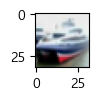

In [23]:
# 6. 모델 사용하기
plt.figure(figsize=(0.7,0.7))
plt.imshow(X_test[1])
y_test[1]

In [24]:
pred = model.predict(X_test[0].reshape(-1,32,32,3)).argmax(axis=1)
pred

1/1 [==============================] - 0s 65ms/step


array([3], dtype=int64)

# 3. VGG
- 옥스퍼드 대 VGG팀에서 구현한 CNN(컨볼루션과 맥스폴링 19개층)
- VGG-19 구현

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
import cv2  # pip install opencv-python : 이미지 사이즈 조정
import matplotlib.pyplot as plt

In [2]:
class Vgg19:
    @staticmethod
    def build(input_shape=(224,224,3),activation='relu',class_num=1000):
        model = Sequential([
            Input(shape=input_shape),
            Conv2D(64, (3,3), activation=activation, padding='same'),
            Conv2D(64, (3,3), activation=activation, padding='same'),
            MaxPooling2D(),
            Conv2D(128, (3,3), activation=activation, padding='same'),
            Conv2D(128, (3,3), activation=activation, padding='same'),
            MaxPooling2D(),
            Conv2D(256, (3,3), activation=activation, padding='same'),
            Conv2D(256, (3,3), activation=activation, padding='same'),
            Conv2D(256, (3,3), activation=activation, padding='same'),
            Conv2D(256, (3,3), activation=activation, padding='same'),
            MaxPooling2D(),
            Conv2D(512, (3,3), activation=activation, padding='same'),
            Conv2D(512, (3,3), activation=activation, padding='same'),
            Conv2D(512, (3,3), activation=activation, padding='same'),
            Conv2D(512, (3,3), activation=activation, padding='same'),
            MaxPooling2D(),
            Conv2D(512, (3,3), activation=activation, padding='same'),
            Conv2D(512, (3,3), activation=activation, padding='same'),
            Conv2D(512, (3,3), activation=activation, padding='same'),
            Conv2D(512, (3,3), activation=activation, padding='same'),
            MaxPooling2D(),
            Flatten(),
            Dense(4096, activation='relu'),
            Dense(4096, activation='relu'),
            Dense(1000, activation='softmax')
        ])
        return model
    

In [3]:
model = Vgg19.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [4]:
vggModel = VGG19() # 학습을 하지 않고 imageNet으로 학습이 끝난 model*weights 내려받아 가중치만 사용
weights = vggModel.get_weights()
model.set_weights(weights=weights) # 학습이 끝난 가중치를 model에 이식
# 추가적인 재학습도 가능함

In [5]:
# model.predict(읽어온이미지를 224*224*3 넘파이배열)
# 예측하기 위해 이미지를 읽어 -> 사이즈 조정(openCV라이브러리: pip install opencv-python)
# 방법 1
img_cv2 = cv2.imread('data/sample.jpg',
                     cv2.IMREAD_COLOR, # BGR포맷, 알파(투명도)채널 무시
                     # cv2.IMREAD_UNCHANGED, # 투명도까지 그대로 읽음
                     # cv2.IMREAD_GRAYSCALE # 흑백으로 읽음
                    )

img_cv2 = cv2.resize(img_cv2, dsize=(224,224),
                     interpolation=cv2.INTER_NEAREST) # 보간법

cv2.imshow('sample', img_cv2)
cv2.waitKey(0) # 키보드입력을 기다림. 이미지가 화면에 표시된 상태를 유지
cv2.destroyAllWindows() # openCV를 통해 생성된 모든 창을 닫음
img_cv2.shape

(224, 224, 3)

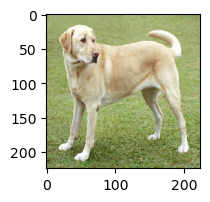

numpy.ndarray

In [6]:
plt.figure(figsize=(2,2))
# BGR 포맷인 img_cv2를 RGB 포맷으로
img_cv2_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
plt.imshow(img_cv2_rgb)
plt.show()
type(img_cv2_rgb)

In [7]:
# 방법2
from tensorflow.keras.preprocessing import image
img = image.load_img('data/sample.jpg', target_size=(224,224))
print(type(img))
img_data = image.img_to_array(img)
print('읽어온 img_data의 type :', type(img_data), ', img_data의 shape :', img_data.shape)

<class 'PIL.Image.Image'>
읽어온 img_data의 type : <class 'numpy.ndarray'> , img_data의 shape : (224, 224, 3)


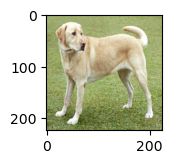

In [8]:
plt.figure(figsize=(1.5,1.5))
plt.imshow(img)
plt.show()

(numpy.ndarray, (577, 700, 3))

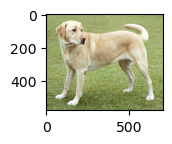

In [9]:
# 방법3
img_data1=plt.imread('data/sample.jpg')
plt.figure(figsize=(1.5,1.5))
plt.imshow(img_data1)
type(img_data1), img_data1.shape

In [10]:
img_data.shape, img_data1.shape

((224, 224, 3), (577, 700, 3))

In [11]:
# 차원 변경 (224, 224,3) => (1,224,224,3)하는 방법들
import numpy as np
a = np.array([1,2,3])
# a의 shape (3, ) => (1,3) : newaxis를 이용한 축추가, reshape을 이용한 shape
print('a 배열의 축 추가(3행1열) :\n', a[:, np.newaxis])
print('a 배열의 축 추가(1행3열) :', a[np.newaxis, :])
print('a 배열의 축 추가(1행3열) :', a[np.newaxis, ...])
print('a 배열의 reshape :', a.reshape(-1,3))

a 배열의 축 추가(3행1열) :
 [[1]
 [2]
 [3]]
a 배열의 축 추가(1행3열) : [[1 2 3]]
a 배열의 축 추가(1행3열) : [[1 2 3]]
a 배열의 reshape : [[1 2 3]]


In [12]:
# 예측하기
pred = model.predict(img_data[np.newaxis, ...])
pred.argmax()

1/1 [==============================] - 3s 3s/step


208

In [13]:
from tensorflow.keras.applications.vgg19 import decode_predictions
result=decode_predictions(pred, top=5)[0]
for row in result:
    print('{}일 확률 : {}%'.format(row[1],round(row[2]*100,2)))

35363/35363 [==============================] - 0s 0us/step
Labrador_retriever일 확률 : 86.14%
kuvasz일 확률 : 8.57%
Weimaraner일 확률 : 1.46%
bloodhound일 확률 : 0.8%
Great_Pyrenees일 확률 : 0.49%


# 4. 인셉션 모듈
- 교안 55pt
    - 1x1 컨볼루션을 하는 이유 : 채널 수를 줄여 연산속도를 높이려고

In [1]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import concatenate

In [2]:
model_input = Input(shape=(28,28,3))
pre = Dense(192)(model_input) # => 28*28*192
conv1 = Conv2D(64,  # 커널(필터) 갯수
               1,   # 커널 사이즈
               padding='same')(pre)
conv2 = Conv2D(128, 3, padding='same')(pre)
conv3 = Conv2D(32, 5, padding='same')(pre)
pool = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(pre)
model_out = concatenate([conv1, conv2, conv3, pool])
model = Model(inputs=model_input, outputs=model_out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 dense (Dense)                  (None, 28, 28, 192)  768         ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 64)   12352       ['dense[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 128)  221312      ['dense[0][0]']                  
                                                                                              

- GoogLeNet 중 Inception 모듈, Bottle Neck 구조
- GoogLeNet에서 소개된 핵심 요소로, 이미지 분류와 같은 작업에서 효율적이고 강력한 성능을 제공

```
![image](image/인셉션모듈.png)
```
<img src="image/인셉션모듈.png" alt="image" width="600">

In [3]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, concatenate
model_input = Input(shape=(28,28,3))
pre = Dense(192)(model_input)

conv1 = Conv2D(64, 1, padding='same')(pre)

conv2_1 = Conv2D(96, 1, padding='same')(pre)
conv2   = Conv2D(128, 3, padding='same')(conv2_1)

conv3_1 = Conv2D(16, 1, padding='same')(pre)
conv3   = Conv2D(32, 5, padding='same')(conv3_1)

pool = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(pre)
conv4 = Conv2D(32, 1, padding='same')(pool)

model_output = concatenate([conv1, conv2, conv3, conv4])

model = Model(inputs=model_input, outputs=model_output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 28, 28, 192)  768         ['input_2[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 28, 28, 96)   18528       ['dense_1[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 28, 28, 16)   3088        ['dense_1[0][0]']                
                                                                                            

# 5. Residual block

```
![Residual Block](image/residual_block.png)
```
<img src="image/residual_block.png" alt="Residual Block" width="200" style="float:left;">

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, add
model_input = Input(shape=(28,28,3))

x = Conv2D(64, 3, padding='same', activation='relu')(model_input)

# residual block
conv = Conv2D(32, 3, padding='same', activation='relu')(x)
conv = Conv2D(64, 3, padding='same', activation='relu')(conv)
y = add([conv, x])
y = Activation('relu')(y)

model_output = Conv2D(64, 3, activation='relu')(y)

model = Model(inputs = model_input, outputs=model_output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 28, 28, 64)   1792        ['input_3[0][0]']                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 28, 28, 32)   18464       ['conv2d_9[0][0]']               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 28, 28, 64)   18496       ['conv2d_10[0][0]']              
                                                                                            

# 6. 케라스 모델 가져오기

In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import decode_predictions
import numpy as np

model = ResNet50()
# weights=None : 랜덤값으로 초기화된 상태의 가중치
# weights='imagenet'(기본값) : imagenet 데이터로 학습이 끝난 가중치 (224,224,3 이미지->1000 분류)
# model.summary()

102967424/102967424 [==============================] - 4s 0us/step


In [7]:
json_str = model.to_json()
# json_str
with open('model/model.json', 'w') as json_file:
    json_file.write(json_str)

In [8]:
from tensorflow.keras.models import model_from_json
with open('model/model.json', 'r') as f:
    json_str2 = f.read()
model2 = model_from_json(json_str2)
# model2.summary()

In [20]:
# 이미지를 예측하기 위해 이미지 파일을 넘파이 배열로 가져오는 방법 4가지
# 방법1
import cv2
img_cv = cv2.imread('data/sample.jpg', cv2.IMREAD_COLOR) # 넘파이 배열(BGR포맷)
img_cv2 = cv2.resize(img_cv, dsize=(224,224), interpolation=cv2.INTER_NEAREST)
img_data = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
print('방법1(모두 넘파이) :', img_data.shape, img_cv2.shape, img_cv.shape)

# 방법2
from tensorflow.keras.preprocessing import image
img = image.load_img('data/sample.jpg', target_size=(224,224)) # Image 타입
img_data = image.img_to_array(img) # 넘파이로 변경
print('방법2(Image타입으로 읽어 넘파이로 변환) :', img_data.shape, type(img))

# 방법3
from matplotlib import pyplot as plt
import cv2
img_plt = plt.imread('data/sample.jpg') # 넘파이배열
img_data = cv2.resize(img_plt, dsize=(224,224), interpolation=cv2.INTER_NEAREST)
print('방법3(모두 넘파이) :', img_data.shape, img_plt.shape)

# 방법4
from PIL import Image # pip install pillow
import numpy as np
import cv2
imageFile = Image.open('data/sample.jpg') # 이미지파일
img_numpy = np.array(imageFile) # 넘파이로 변경
img_data = cv2.resize(img_numpy, dsize=(224,224), interpolation=cv2.INTER_NEAREST)
print('방법4 :', img_data.shape)

방법1(모두 넘파이) : (224, 224, 3) (224, 224, 3) (577, 700, 3)
방법2(Image타입으로 읽어 넘파이로 변환) : (224, 224, 3) <class 'PIL.Image.Image'>
방법3(모두 넘파이) : (224, 224, 3) (577, 700, 3)
방법4 : (224, 224, 3)


In [26]:
# 모델 사용하기
# 모델 예측시 매개변수로 들어갈 데이터의 축 추가
# 방법1
x = np.expand_dims(img_data, axis=0)
print('방법1 :', x.shape)
# 방법2
x = img_data[np.newaxis, ...]
print('방법2 :', x.shape)
# 방법3
x = img_data[np.newaxis, :]
print('방법3 :', x.shape)
# 방법4
x = img_data.reshape(-1, 224, 224, 3)
print('방법4 :', x.shape)

방법1 : (1, 224, 224, 3)
방법2 : (1, 224, 224, 3)
방법3 : (1, 224, 224, 3)
방법4 : (1, 224, 224, 3)


In [28]:
pred = model.predict(x)
pred.argmax()

1/1 [==============================] - 0s 195ms/step


208

In [32]:
decode_predictions(pred, top=3)

[[('n02099712', 'Labrador_retriever', 0.115230106),
  ('n02108089', 'boxer', 0.1123909),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.106657766)]]

# 7. 전이학습

In [37]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
resnet_model = ResNet50(input_shape=(200,200,3),
                        include_top=False) # 모델의 최상위 계층은 포함하지 않고 가져옴. 전이학습시 사용
resnet_model.trainable = True # 가중치의 업데이트 허용
# resnet_model.trainable = False : 기존의 ResNet50의 가중치는 고정. 새로 추가된 가중치만 

model = Sequential()
model.add(resnet_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 1024)              102761472 
                                                                 
 dense_5 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 126,352,259
Trainable params: 126,299,139
Non-trainable params: 53,120
_________________________________________________________________
